In [1]:
import os

github_token = os.getenv('GITHUB_TOKEN')
openai_key = os.getenv('OPENAI_KEY')

In [11]:
import requests
import base64

# GitHubの個人アクセストークンとリポジトリ情報
TOKEN = github_token
REPO = 'M-asaki-K/chatbot_mathopt'  # リポジトリ名
FILE_PATH = ''  # 取得したいファイルのパス

# APIエンドポイントの設定
url = f'https://api.github.com/repos/{REPO}/contents/{FILE_PATH}'
# ヘッダーにトークンを設定
headers = {'Authorization': f'token {TOKEN}'}

# リクエストの送信
response = requests.get(url, headers=headers)

# レスポンスの確認
if response.status_code == 200:
    file_content = response.json()
else:
    print('Failed to retrieve file')

In [3]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key=openai_key)
memory = ConversationBufferMemory(memory_key="chat_history")


In [4]:
import requests

# GitHubからディレクトリの内容を取得
response = requests.get(url)
data = response.json()

# CSVファイルのURLを見つける
csv_urls = [item['download_url'] for item in data if item['name'].endswith('.csv')]

# CSVファイルの内容をダウンロード
csv_contents = {}
for url in csv_urls:
    filename = url.split('/')[-1]
    content = requests.get(url).text
    csv_contents[filename] = content

# CSVファイルのURLを見つける
jn_urls = [item['download_url'] for item in data if item['name'].endswith('.py')]

# CSVファイルの内容をダウンロード
jn_contents = {}
for url in jn_urls:
    filename_jn = url.split('/')[-1]
    content_jn = requests.get(url).text
    jn_contents[filename_jn] = content_jn


In [5]:
jn_contents

{'ClassAssignment.py': 'import pandas as pd\r\nimport pulp\r\nimport matplotlib.pyplot as plt\r\nimport inspect\r\n\r\nclass ClassAssignment:\r\n    def __init__(self, student_csv, pair_csv, classes):\r\n        self.student_df = pd.read_csv(student_csv)\r\n        self.pair_df = pd.read_csv(pair_csv)\r\n        self.classes = classes\r\n        self.problem = pulp.LpProblem(\'ClassAssignmentProblem\', pulp.LpMaximize)\r\n        self.students = self.student_df[\'student_id\'].tolist()\r\n        self.student_class_pairs = [(s, c) for s in self.students for c in self.classes]\r\n        self.assignment_vars = pulp.LpVariable.dicts(\'x\', self.student_class_pairs, cat=\'Binary\')\r\n        self.total_students = len(self.students)\r\n        self.students_per_class = self.total_students // len(self.classes)\r\n        \r\n    def apply_all_constraints(self):\r\n        # メソッド名が \'set_\' で始まるすべてのメソッドを取得して実行\r\n        for name, method in inspect.getmembers(self, predicate=inspect.ismetho

In [6]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain

# プロンプトテンプレートの設定
template_script = """
{py_file}
上記のpyファイルを参照し、下記の新たな制約条件「{constraints}」を反映するには、スクリプトにどういうコードを付加すべきか、必要十分な関数として記載せよ。回答はスクリプトのみでよい。
＜例＞
def set_hoge_constraints(self):
    …
    constraint = …
    self.problem += constraint, …

Chatbot:
"""

template_script = """
{py_file}を参照し、次の新たな制約「{constraints}」を反映するために追加すべきPython関数を記述せよ。コメントや不要なマークアップは含めず、関数の定義のみを提供すること。
"""

# スクリプトのプロンプトテンプレート作成
prompt_script = PromptTemplate(
    input_variables=["py_file", "constraints"],
    template=template_script
)

# 制約条件の設定
constraints = "ピアノが弾ける生徒を各クラスに一人以上入れたい。"

prompt_script

# Pythonスクリプトの解析用LLMChainの作成と実行
llm_chain = LLMChain(llm=llm, prompt=prompt_script)
response = llm_chain.run(py_file=jn_contents["ClassAssignment.py"], constraints=constraints)

def clean_code(code):
    # 不要なマークダウンや言語指定を削除
    clean_code = code.replace("```python", "").replace("```", "").strip()
    return clean_code

print(clean_code(response))


c:\Users\uni21\miniconda3\envs\mathopt\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


def set_piano_player_constraints(self):
        piano_players = [s for s in self.students if self.student_df.loc[s-1, 'piano_flag'] == 1]
        for c in self.classes:
            constraint = pulp.lpSum([self.assignment_vars[s, c] for s in piano_players]) >= 1
            self.problem += constraint, f"min_piano_players_in_class_{c}"


In [7]:
function_to_add = clean_code(response)

In [8]:
# プロンプトテンプレートの設定
template_script = """
{py_file}
上記のpyファイルを参照し、下記の新たな制約関数を反映するには、元々のデータに加えてどういうデータ形式が必要か出力せよ。出力はcsvの例（列名とはじめ数行）のみでよい。コメントやマークアップは記載しないこと。
＜制約関数＞
{constraints}

Chatbot:
"""

# スクリプトのプロンプトテンプレート作成
prompt_script_data = PromptTemplate(
    input_variables=["py_file", "constraints"],
    template=template_script
)

# 制約条件の設定
constraints = response

# Pythonスクリプトの解析用LLMChainの作成と実行
llm_chain_data = LLMChain(llm=llm, prompt=prompt_script_data)
response_data = llm_chain_data.run(py_file=jn_contents["ClassAssignment.py"], constraints=constraints)

# 解析結果の表示
print(response_data)


student_id,gender,score,leader_flag,support_flag,piano_flag
1,0,450,1,0,1
2,1,400,0,1,0
3,0,350,0,1,1
4,1,300,0,0,0
5,0,250,1,0,0
6,1,200,0,1,1
7,0,150,0,0,0
8,1,100,1,1,0
9,0,50,0,0,1
10,1,450,0,1,0


In [ ]:
import pandas as pd
from io import StringIO

response_data_csv = pd.read_csv(StringIO(response_data))
response_data_csv.to_csv("students_rev.csv", index = False)

import pandas as pd
import pulp
import matplotlib.pyplot as plt
import inspect

class ClassAssignment:
    def __init__(self, student_csv, pair_csv, classes):
        self.student_df = pd.read_csv(student_csv)
        self.pair_df = pd.read_csv(pair_csv)
        self.classes = classes
        self.problem = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)
        self.students = self.student_df['student_id'].tolist()
        self.student_class_pairs = [(s, c) for s in self.students for c in self.classes]
        self.assignment_vars = pulp.LpVariable.dicts('x', self.student_class_pairs, cat='Binary')
        self.total_students = len(self.students)
        self.students_per_class = self.total_students // len(self.classes)
        
    def apply_all_constraints(self):
        # メソッド名が 'set_' で始まるすべてのメソッドを取得して実行
        for name, method in inspect.getmembers(self, predicate=inspect.ismethod):
            if name.startswith("set_"):
                method()

    def set_student_c

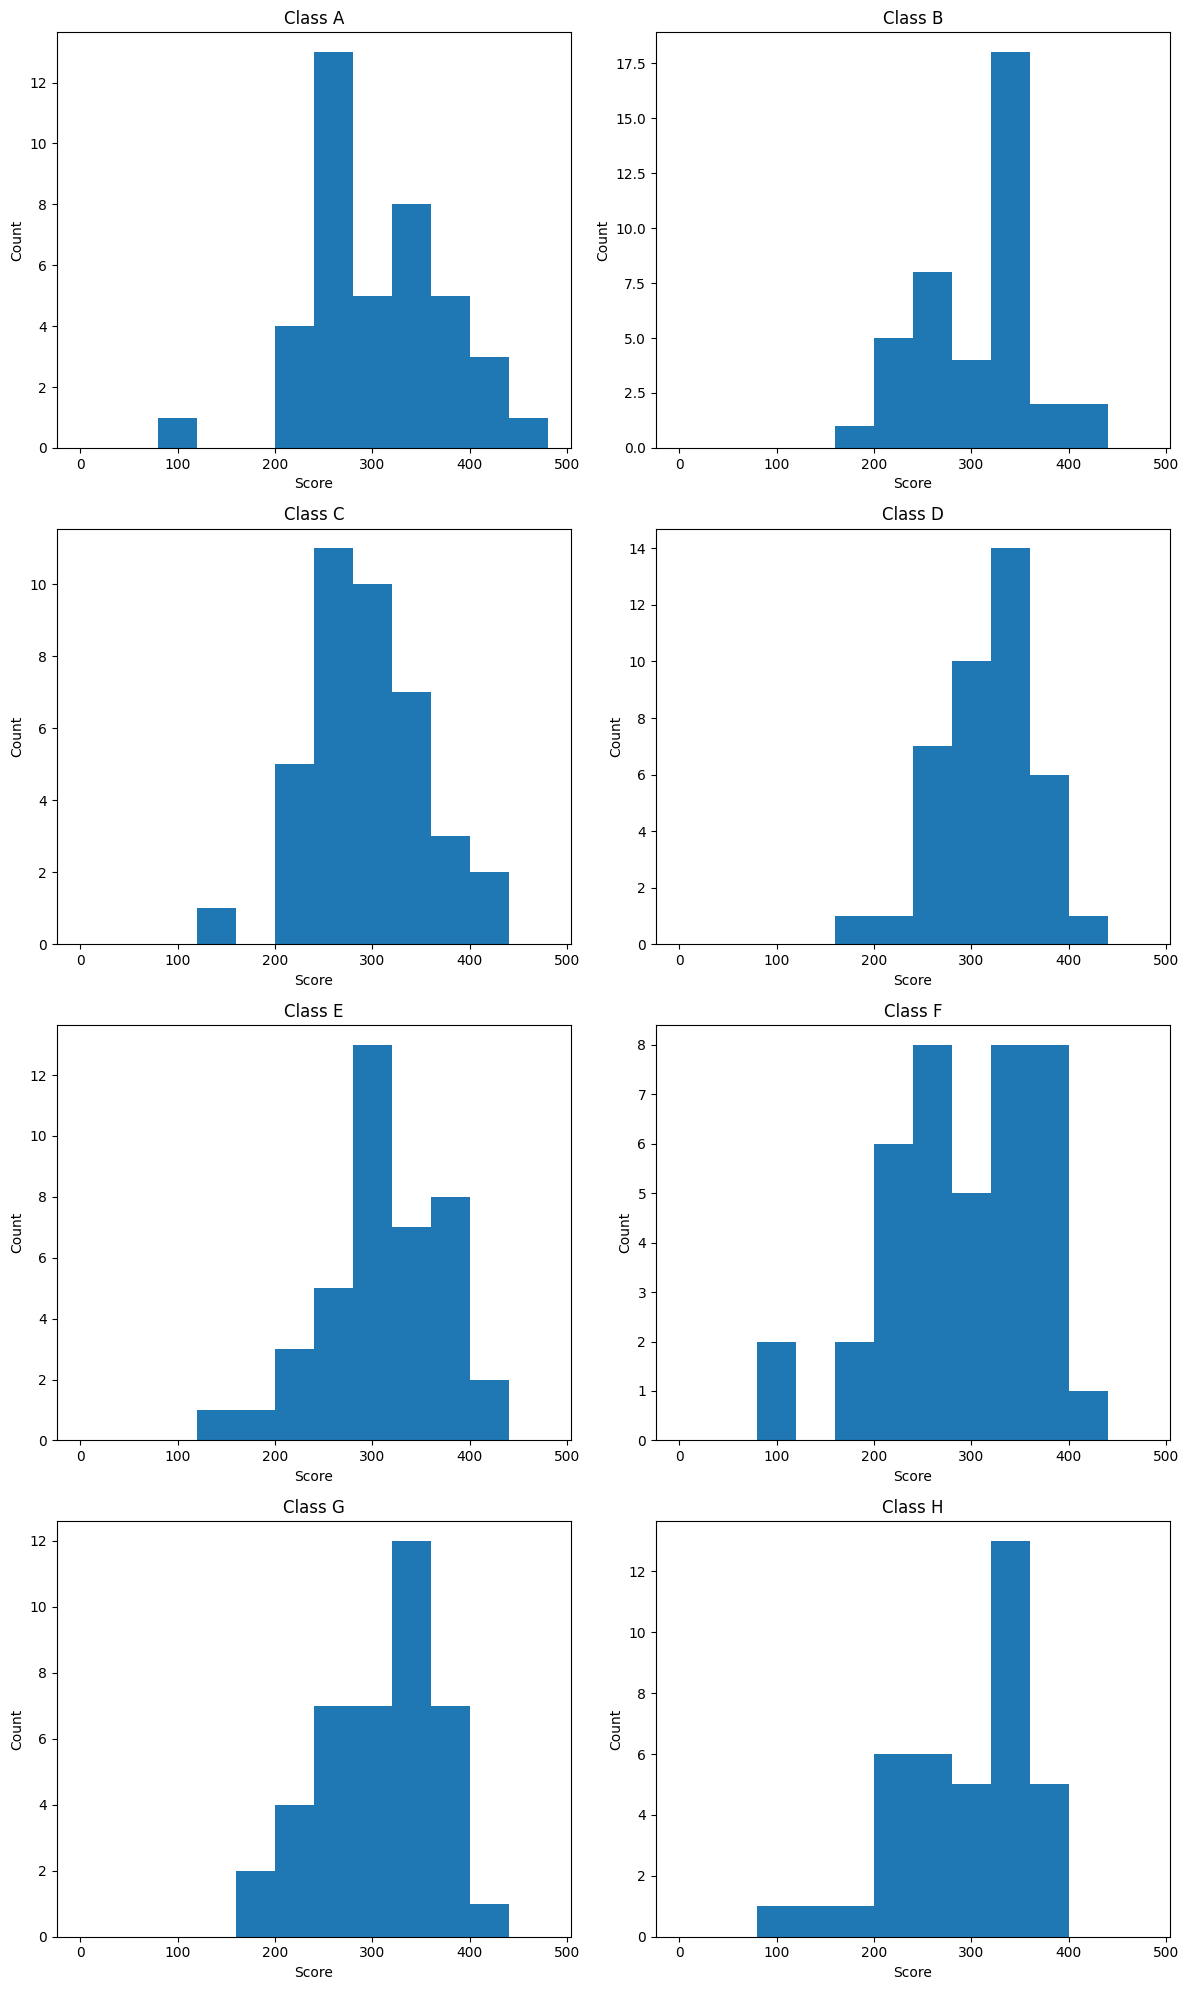

In [9]:
import shutil
import tempfile
import importlib.util
import os

def add_function_and_import(filepath, function_code, module_name):
    # 一時ファイルを作成し、新しい関数を追加
    temp_dir = tempfile.mkdtemp()
    temp_filepath = shutil.copy(filepath, temp_dir)
    with open(temp_filepath, 'a') as file:
        file.write('\n\n' + function_code)
    
    # 確認のため、追加後のファイル内容を表示
    with open(temp_filepath, 'r') as file:
        print(file.read())

    # 一時ファイルからモジュールを動的にインポート
    spec = importlib.util.spec_from_file_location(module_name, temp_filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    
    # 一時ファイルのパスを返す
    return module, temp_filepath

def clean_up(temp_dir):
    # ディレクトリとその中身を再帰的に削除
    shutil.rmtree(temp_dir)

def escape_and_indent_python_code(code, initial_indent=4, indent_size=4):
    # インデントを追加するための関数
    def add_indent(line, num_indent):
        return ' ' * num_indent + line

    # 一行ごとに処理
    lines = code.strip().split('\n')
    indented_lines = [add_indent(line, initial_indent + (i > 0) * indent_size) for i, line in enumerate(lines)]
    return '\n'.join(indented_lines)

function_to_add_indented = escape_and_indent_python_code(function_to_add)
# ファイルに関数を追加してモジュールをインポート
class_assignment_module, temp_file = add_function_and_import('ClassAssignment.py', function_to_add_indented, 'ClassAssignment')

# モジュールからクラスをインスタンス化して、特定の制約をテストする
assignment = class_assignment_module.ClassAssignment('students_rev.csv', 'student_pairs.csv', ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
assignment.apply_all_constraints()  # すべての制約を自動で適用
status = assignment.solve()
print(f'Status: {status}')
assignment.plot_results()
assignment.save_class_assignments()